# 1083 Albumin Initial ML

### By: Ian Weimer

## Imports

In [18]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
import math
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import cross_val_score
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
import warnings
from sklearn.compose import make_column_transformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import balanced_accuracy_score
import graphviz
import pydotplus
pd.set_option('display.max_columns', None)

## Load Albumin Data From Pre-processing and Exploratory Analysis

In [19]:
df = pd.read_csv('C:/Users/Iweimer/Desktop/BB_Git/1083-albumin-data-exploration/ML/K72_Cohort/Tables/K72_HF_MATCHED_alb_24hrs.csv')

In [20]:
df.LOS_days.describe()

count    6810.000000
mean        8.723147
std         8.635517
min         0.000000
25%         2.575651
50%         5.904861
75%        12.090625
max        50.389583
Name: LOS_days, dtype: float64

## Look at outcomes distributions between patients who did and didn't receive albumin within 24 hrs

In [21]:
df[df['albumin_24hrs'] == 1].LOS_days.describe()

count    3405.000000
mean        9.511331
std         8.852425
min         0.196528
25%         3.058333
50%         6.601389
75%        13.002778
max        49.184722
Name: LOS_days, dtype: float64

In [22]:
df[df['albumin_24hrs'] == 0].LOS_days.describe()

count    3405.000000
mean        7.934963
std         8.340140
min         0.000000
25%         2.090972
50%         5.104167
75%        10.893750
max        50.389583
Name: LOS_days, dtype: float64

## Convert LOS_days to Categorical

In [23]:
# Calculate Tertiles

q1 = df['LOS_days'].quantile(q=(1/3))
q2 = df['LOS_days'].quantile(q=(2/3))
print(q1)
print(q2)

3.527083333333333
9.288657407407406


In [24]:
# bin the LOS_days var

LOS = df['LOS_days']
m = max(LOS)

bins = [0, 3.53, 9.29, m]
labels=[0, 1, 2]

# 0 - Low/Short Length of Stay
# 1 - Medium Length of Stay
# 2 - High/Long Length of Stay

df['LOS_days'] = pd.cut(LOS, bins=bins, labels=labels, include_lowest=True)

In [25]:
df['LOS_days'].value_counts()

0    2274
2    2269
1    2267
Name: LOS_days, dtype: int64

In [26]:
df.head()

personid                           encounterid  \
0  01013827-c0f0-42be-bc96-1ac714b7aaeb  7859a028-911e-452c-ad3f-c04f85f4a9c7   
1  14e14f39-6c68-4356-be3e-f62f9d6b65c2  af7e9a58-0837-49e0-86b2-e6781ea942f4   
2  2b67cff8-4f3a-4aa0-8fa0-1d342b88e516  9fd9125a-e53c-47ef-ad19-8a72d171897f   
3  3d335201-ebbc-47ec-881e-5e9eb6d6c681  7e925b39-2be4-4bf1-91d2-1dc475764426   
4  6c4ab780-b870-43d3-a9ec-253f457d6dc6  f2a08cf1-ff10-4ca4-863f-663e0b3d12e7   

    age  sex  ICU  bl_albumin_value  hgb_bl  beta_blocker  Cirrhosis  CCI  \
0  68.0    1    0               2.8    11.5             0          1    3   
1  37.0    0    1               2.7    15.5             0          0    2   
2  76.0    0    1               1.8    10.0             0          0    5   
3  30.0    1    1               1.8    14.4             0          1    3   
4  44.0    1    0               1.9     8.1             0          1    7   

   qSOFA    MELD  SEWS  ACLF  albumin_24hrs  albumin LOS_days  \
0      0  23.508     0     0              1        1        0   
1      2  22.640     3     1              1        1        1   
2      1  16.000     2     1              1        1        2   
3      0  33.848     2     2              1        1        1   
4      2  37.990     1     1              1        1        2   

   90_day_mortality  90_day_readmission  hospital_free_days  
0                 1                 0.0                   0  
1                 1                 0.0                   0  
2                 0                 0.0                  33  
3                 0                 1.0                   7  
4                 1                 0.0                   0

In [27]:
df.shape

(6810, 20)

In [28]:
df.drop(columns=['encounterid', 'personid', 'albumin'], inplace=True)

In [29]:
df.drop(columns=['90_day_mortality', '90_day_readmission', 'hospital_free_days'], inplace=True)

In [30]:
df.head()

age  sex  ICU  bl_albumin_value  hgb_bl  beta_blocker  Cirrhosis  CCI  \
0  68.0    1    0               2.8    11.5             0          1    3   
1  37.0    0    1               2.7    15.5             0          0    2   
2  76.0    0    1               1.8    10.0             0          0    5   
3  30.0    1    1               1.8    14.4             0          1    3   
4  44.0    1    0               1.9     8.1             0          1    7   

   qSOFA    MELD  SEWS  ACLF  albumin_24hrs LOS_days  
0      0  23.508     0     0              1        0  
1      2  22.640     3     1              1        1  
2      1  16.000     2     1              1        2  
3      0  33.848     2     2              1        1  
4      2  37.990     1     1              1        2

In [31]:
# remove variables

# df.drop(columns=['anemia_status', 'SAPS', 'qSOFA', 'mass_transfusion'], inplace=True)

In [32]:
df.describe()

age          sex          ICU  bl_albumin_value       hgb_bl  \
count  6810.000000  6810.000000  6810.000000       6810.000000  6810.000000   
mean     59.170044     0.582526     0.300881          2.212140    11.084104   
std      14.546238     0.493179     0.458675          0.465151     2.700672   
min      10.000000     0.000000     0.000000          0.600000     3.500000   
25%      50.000000     0.000000     0.000000          1.900000     9.200000   
50%      60.000000     1.000000     0.000000          2.200000    11.100000   
75%      69.000000     1.000000     1.000000          2.600000    12.900000   
max      89.000000     1.000000     1.000000          4.000000    19.900000   

       beta_blocker    Cirrhosis          CCI        qSOFA         MELD  \
count   6810.000000  6810.000000  6810.000000  6810.000000  6810.000000   
mean       0.239354     0.648752     4.672687     1.086050    25.236836   
std        0.426720     0.477395     2.848745     0.903443     8.411879   
min        0.000000     0.000000     0.000000     0.000000     6.000000   
25%        0.000000     0.000000     3.000000     0.000000    19.237000   
50%        0.000000     1.000000     4.000000     1.000000    25.237000   
75%        0.000000     1.000000     6.000000     2.000000    31.290000   
max        1.000000     1.000000    17.000000     3.000000    40.000000   

              SEWS         ACLF  albumin_24hrs  
count  6810.000000  6810.000000    6810.000000  
mean      2.291483     1.586490       0.500000  
std       2.385840     1.088502       0.500037  
min       0.000000     0.000000       0.000000  
25%       0.000000     1.000000       0.000000  
50%       2.000000     2.000000       0.500000  
75%       4.000000     2.000000       1.000000  
max      16.000000     6.000000       1.000000

In [33]:
#df = df[['CCI', 'unknown_albumin_type', 'albumin_24hrs', '25_percent_albumin', 'LOS_days']]

## Modeling

In [34]:
# establish target feature, LOS_days, as y feature
y = df['LOS_days']
# drop target feature from features dataframe
X = df.drop(columns = ['LOS_days'], axis = 1)
# save dataframe column titles to list for reassigning after min max scale 
cols = X.columns

In [35]:
cols

Index(['age', 'sex', 'ICU', 'bl_albumin_value', 'hgb_bl', 'beta_blocker',
       'Cirrhosis', 'CCI', 'qSOFA', 'MELD', 'SEWS', 'ACLF', 'albumin_24hrs'],
      dtype='object')

## Standardize Data

In [36]:
#cols = X.columns

#instantiate min-max scaling object
#mm = MinMaxScaler()
# fit and transform feature dataframe
#X = pd.DataFrame(mm.fit_transform(X))
# reassign column names so new dataframe has corresponding names
#X.columns = cols

In [37]:
X.head()

age  sex  ICU  bl_albumin_value  hgb_bl  beta_blocker  Cirrhosis  CCI  \
0  68.0    1    0               2.8    11.5             0          1    3   
1  37.0    0    1               2.7    15.5             0          0    2   
2  76.0    0    1               1.8    10.0             0          0    5   
3  30.0    1    1               1.8    14.4             0          1    3   
4  44.0    1    0               1.9     8.1             0          1    7   

   qSOFA    MELD  SEWS  ACLF  albumin_24hrs  
0      0  23.508     0     0              1  
1      2  22.640     3     1              1  
2      1  16.000     2     1              1  
3      0  33.848     2     2              1  
4      2  37.990     1     1              1

## Train Test Split

In [38]:
# train test split from target feature series and the predicting feature dataframe (set test size to 20% of data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 33)

## Multinomial Logistic Regression

In [39]:
# instantiate a Logistic Regression model without an intercept, 'liblinear' solver method
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# fit the model to X and y training sets
logreg.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(multi_class='multinomial')

Feature: age Score: 0.00806
Feature: sex Score: -0.01151
Feature: ICU Score: -0.18286
Feature: bl_albumin_value Score: -0.13470
Feature: hgb_bl Score: -0.00047
Feature: beta_blocker Score: -0.47065
Feature: Cirrhosis Score: -0.08267
Feature: CCI Score: -0.04067
Feature: qSOFA Score: -0.10732
Feature: MELD Score: 0.01185
Feature: SEWS Score: 0.06341
Feature: ACLF Score: 0.06007
Feature: albumin_24hrs Score: -0.29235


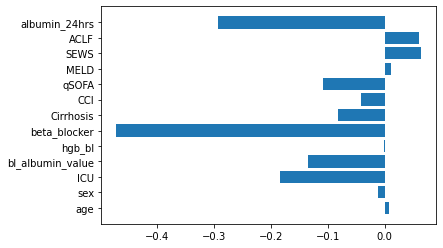

In [40]:
# general quick feature importance
# get coefficients for importance
# coefficients represent the log odds that an observation is in the
# target class, given the values of its X variables

importance = logreg.coef_[0]
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

                  Importance
SEWS                1.065469
ACLF                1.061912
MELD                1.011922
age                 1.008092
hgb_bl              0.999530
sex                 0.988554
CCI                 0.960149
Cirrhosis           0.920656
qSOFA               0.898241
bl_albumin_value    0.873975
ICU                 0.832881
albumin_24hrs       0.746506
beta_blocker        0.624595


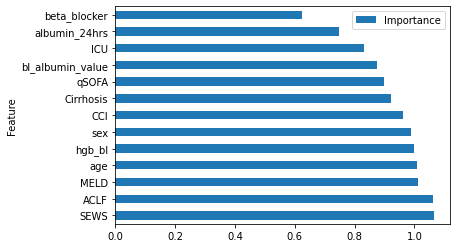

In [41]:
# convert log odds into regular odds with exponentiation
# np.exp()
# and list values, visualize in bar plot

odds = np.exp(logreg.coef_[0])
feature_importance = \
            pd.DataFrame(odds, 
             X.columns, 
             columns=['Importance'])\
            .sort_values(by='Importance', ascending=False)
        
ax = feature_importance.plot.barh(xlabel='Feature', ylabel='Importance')
print(feature_importance)
plt.show()

In [42]:
# Generate model prediction data for train and test sets
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

In [43]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[930 550 363]
 [602 739 477]
 [540 488 759]]


In [44]:
# model metrics for training set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.45      0.50      0.48      1843
           1       0.42      0.41      0.41      1818
           2       0.47      0.42      0.45      1787

    accuracy                           0.45      5448
   macro avg       0.45      0.45      0.44      5448
weighted avg       0.45      0.45      0.44      5448



In [45]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[210 129  92]
 [133 189 127]
 [128 146 208]]


In [46]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.45      0.49      0.47       431
           1       0.41      0.42      0.41       449
           2       0.49      0.43      0.46       482

    accuracy                           0.45      1362
   macro avg       0.45      0.45      0.45      1362
weighted avg       0.45      0.45      0.45      1362



## 1: Decision Tree 

In [84]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=10, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=100)

Feature: age Score: 0.10527
Feature: sex Score: 0.00000
Feature: ICU Score: 0.03088
Feature: bl_albumin_value Score: 0.01900
Feature: hgb_bl Score: 0.00965
Feature: beta_blocker Score: 0.22136
Feature: Cirrhosis Score: 0.05689
Feature: CCI Score: 0.08928
Feature: qSOFA Score: 0.00770
Feature: MELD Score: 0.10340
Feature: SEWS Score: 0.18407
Feature: ACLF Score: 0.10003
Feature: albumin_24hrs Score: 0.07247


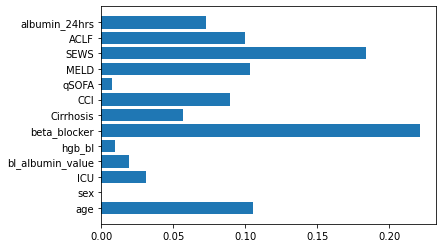

In [85]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [86]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [87]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1013  532  298]
 [ 602  869  347]
 [ 472  606  709]]


In [88]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.49      0.55      0.52      1843
           1       0.43      0.48      0.45      1818
           2       0.52      0.40      0.45      1787

    accuracy                           0.48      5448
   macro avg       0.48      0.47      0.47      5448
weighted avg       0.48      0.48      0.47      5448



In [89]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[192 165  74]
 [147 206  96]
 [133 186 163]]


In [90]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.41      0.45      0.43       431
           1       0.37      0.46      0.41       449
           2       0.49      0.34      0.40       482

    accuracy                           0.41      1362
   macro avg       0.42      0.41      0.41      1362
weighted avg       0.42      0.41      0.41      1362



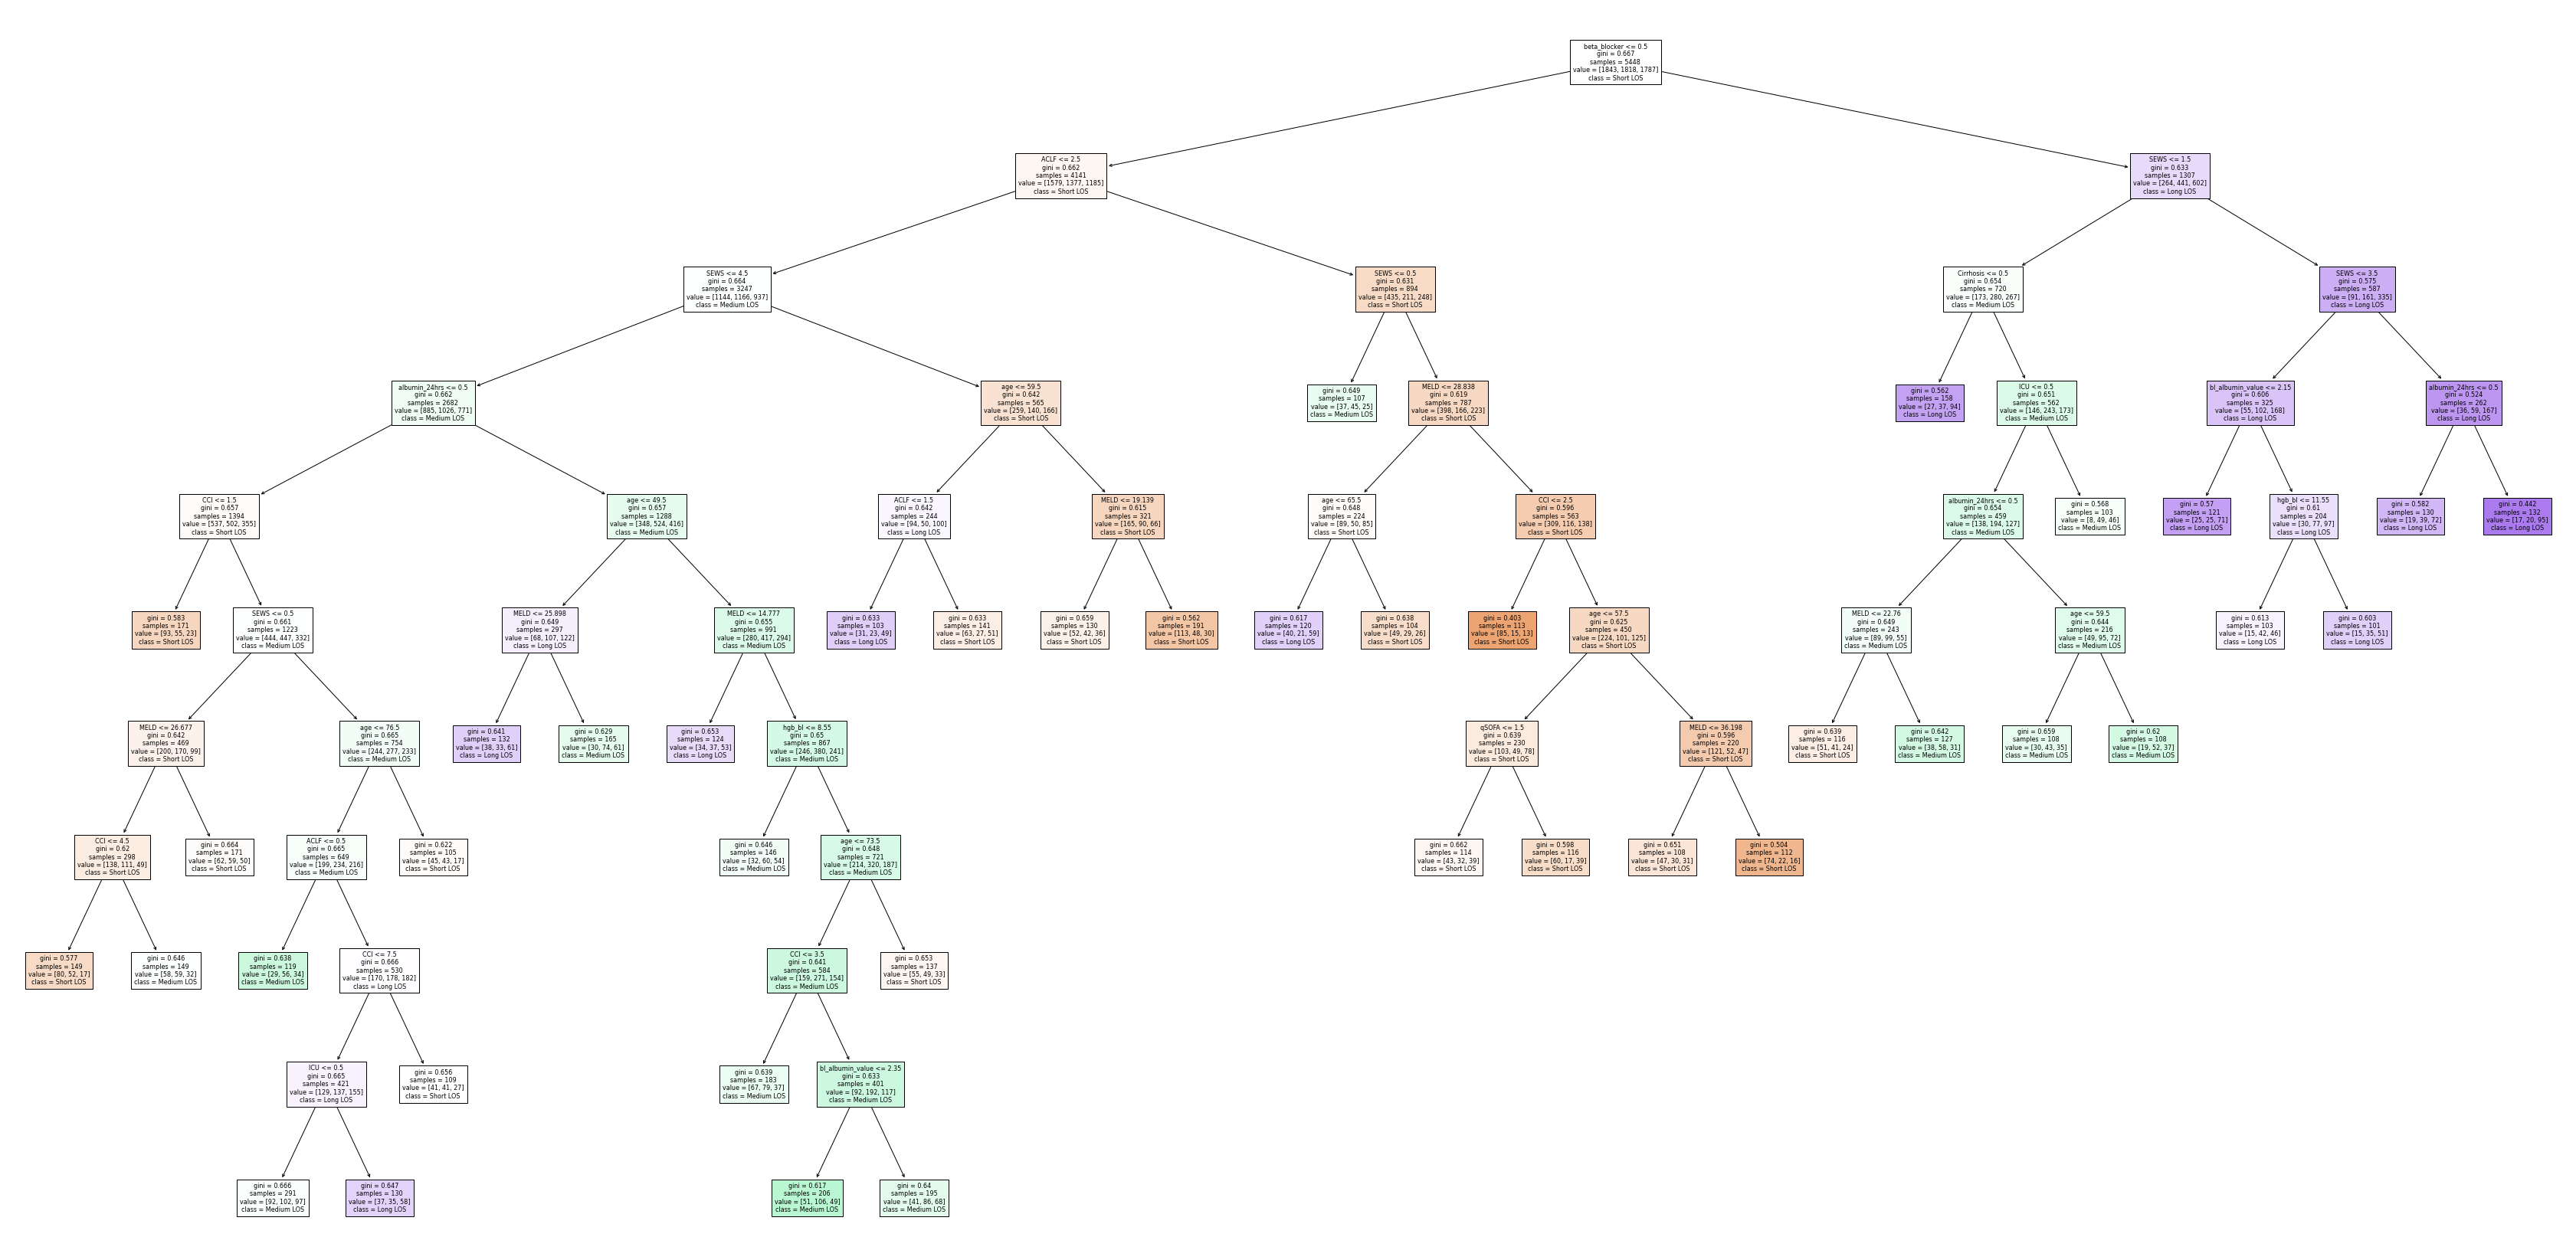

In [91]:
feature_names = X_train.columns.tolist()
class_names = ['Short LOS', 'Medium LOS', 'Long LOS']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [92]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('LOS_DT_D10_PSM_MATCHED.png')

True

## Random Forest

In [57]:
rf = RandomForestClassifier(max_depth=8, min_samples_leaf=100)
# fit the model to X and y training sets
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=100)

In [58]:
# generate model prediction data for train and test sets
y_hat_train = rf.predict(X_train)
y_hat_test = rf.predict(X_test)

In [59]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1103  520  220]
 [ 592  878  348]
 [ 516  546  725]]


In [60]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.50      0.60      0.54      1843
           1       0.45      0.48      0.47      1818
           2       0.56      0.41      0.47      1787

    accuracy                           0.50      5448
   macro avg       0.50      0.50      0.49      5448
weighted avg       0.50      0.50      0.49      5448



In [61]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[222 156  53]
 [138 208 103]
 [148 163 171]]


In [62]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.44      0.52      0.47       431
           1       0.39      0.46      0.43       449
           2       0.52      0.35      0.42       482

    accuracy                           0.44      1362
   macro avg       0.45      0.44      0.44      1362
weighted avg       0.45      0.44      0.44      1362



Feature: age Score: 0.08920
Feature: sex Score: 0.00772
Feature: ICU Score: 0.02876
Feature: bl_albumin_value Score: 0.04645
Feature: hgb_bl Score: 0.05081
Feature: beta_blocker Score: 0.20021
Feature: Cirrhosis Score: 0.05758
Feature: CCI Score: 0.09372
Feature: qSOFA Score: 0.03238
Feature: MELD Score: 0.09378
Feature: SEWS Score: 0.13381
Feature: ACLF Score: 0.09087
Feature: albumin_24hrs Score: 0.07471


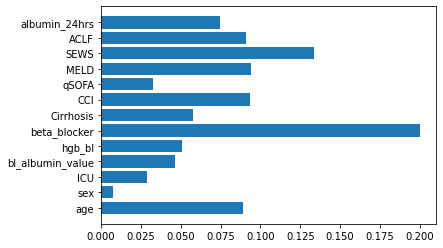

In [63]:
# get importance from decision tree model
importance = rf.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()